###Transformer for sense of humor

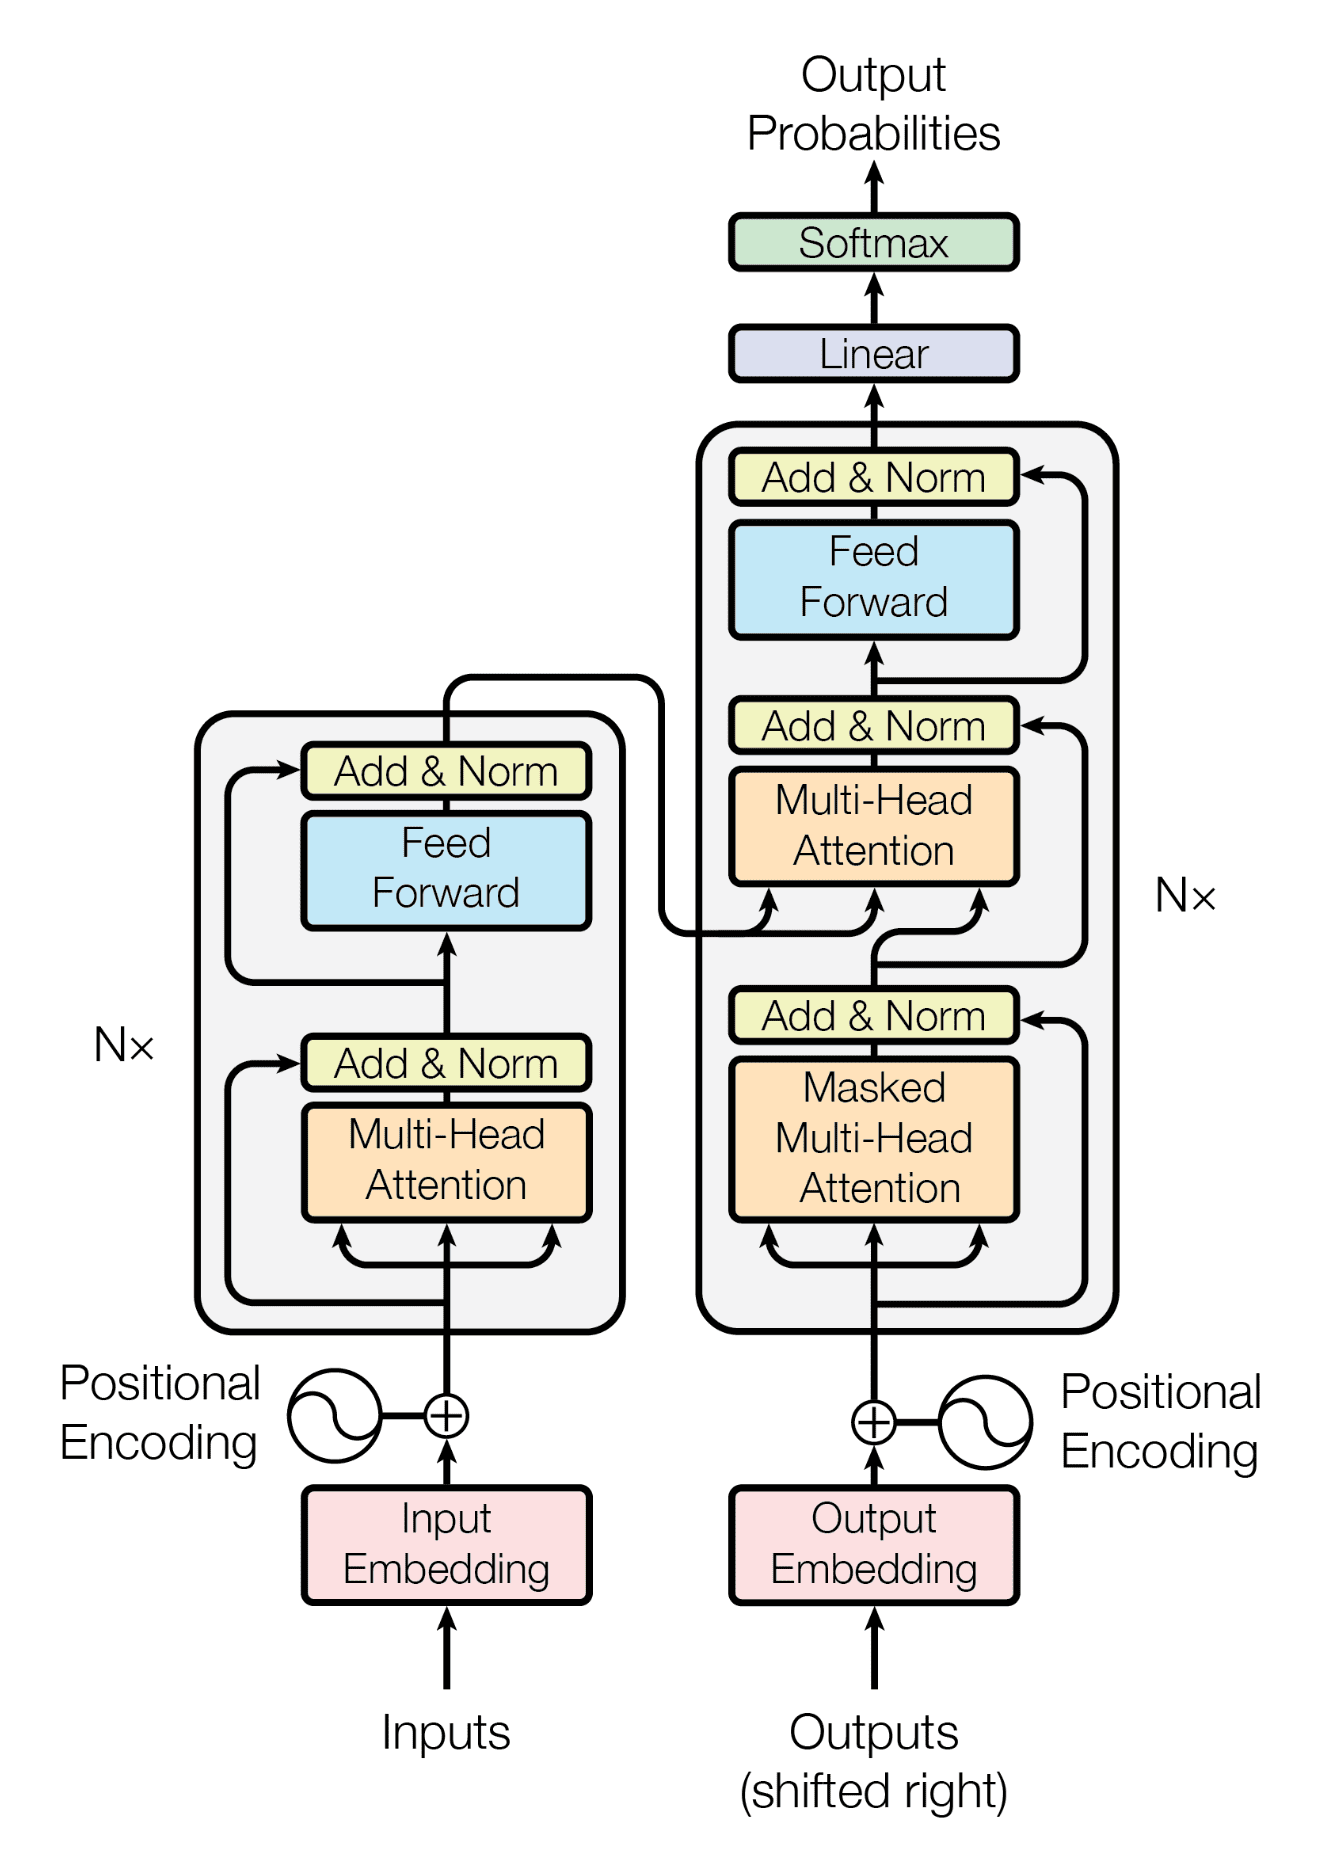

##Tokenizer

In [ ]:
!pip install tokenizers#run this command to install huggin face tokenizers

In [ ]:
def tokenizerPreprocess(text):
  text = text.lower()
  text = ''.join(c for c in text if c.isalnum() or c in [' ', '!', '?', '.', '-', ':'])
  return text

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [ ]:
!pip install huggingface_hub

Total datasets: <generator object HfApi.list_datasets at 0x7a9a8b46f100>


In [ ]:
from tokenizers import Tokenizer,models, trainers, pre_tokenizers, processors
from datasets import load_dataset,DatasetDict,Dataset #I will use a ready made dataset in the tokenizer training
from tokenizers.processors import TemplateProcessing
import pandas as pd

datasets = [
    "imdb",       # Movie reviews dataset for sentiment analysis
    "squad",      # Stanford Question Answering Dataset
    #"cnn_dailymail",  # News articles dataset for summarization tasks
    #"wikitext",   # Text dataset for language modeling
    #"glue",       # General language understanding evaluation (a set of tasks)
    "yelp_polarity",  # Yelp reviews dataset for binary sentiment classification
    "coqa",        # Conversational Question Answering dataset
    "ag_news"
]#commented datasets have problems in the configuration, please don't uncomment those datasets: Samer
#dataset = load_dataset("ag_news")#just a suggested dataset for the training
total_train= None
total_test= None

for ds in datasets:
  dataset=load_dataset(ds)

  if total_train is None:
    total_train= dataset['train'].to_pandas() # Convert to pandas DataFrame
    #total_train= dataset['train']
  else:
    total_train = pd.concat([total_train, dataset['train'].to_pandas()]) # Concatenate using pandas
   #total_train = total_train.concatenate(dataset['train'])

# Check if the dataset has a 'test' split before accessing it
  if 'test' in dataset:
    if total_test is None:
      total_test= dataset['test'].to_pandas() # Convert to pandas DataFrame
     #total_test= dataset['test']
    else:
      total_test = pd.concat([total_test, dataset['test'].to_pandas()]) # Concatenate using pandas
      #total_test = total_test.concatenate(dataset['test'])


combined_dataset= DatasetDict({'train': Dataset.from_pandas(total_train), 'test':Dataset.from_pandas(total_test)}) # Convert back to Dataset
#combined_dataset= DatasetDict({'train': total_train, 'test':total_test})

#print(dataset)
#print(dataset["train"][0])
tokenizer = Tokenizer(models.BPE())#initialize the tokenizer using the byte pair encoding technique

trainer = trainers.BpeTrainer(vocab_size=15000,special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
#[PAD] -> padding to fill sequence with the same length
#[UNK] -> Unkown token for words that aren't in the vocab
#[CLS] -> mark the beginning of the input
#[SEP] -> separator token, usually split two diffferent segments in taks like question answering
#vocab_size=5000 : means that the maximum size of vocab is 5000
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

def get_training_corpus():

    # Iterate over the combined dataset, not the last individual dataset
  for i in range(0, len(combined_dataset['train']), 1000):
    # Handle potential KeyError for missing 'text' column
    try:
      yield [str(x) for x in combined_dataset['train'][i:i+1000]['text']]
      #yield combined_dataset['train'][i:i+1000]['text']
    except KeyError:
      # If 'text' is missing, try other common column names
      try:
        yield [str(x) for x in combined_dataset['train'][i:i+1000]['sentence']]
        #yield combined_dataset['train'][i:i+1000]['sentence']
      except KeyError:
        try:
          yield [str(x) for x in combined_dataset['train'][i:i+1000]['question']]
          #yield combined_dataset['train'][i:i+1000]['question']
        except KeyError:
          # If none of the common names are found, skip this batch
          print(f"Warning: Skipping batch {i}-{i+1000} due to missing text column.")
          continue # Skip to the next batch
tokenizer.train_from_iterator(get_training_corpus(),trainer=trainer)

tokenizer.post_processor = TemplateProcessing(

  single ="[CLS] $A [SEP]",
  pair="[CLS] $A [SEP] $B:1 [SEP]:1",
  special_tokens=[
        ("[CLS]", tokenizer.token_to_id("[CLS]")),
        ("[SEP]", tokenizer.token_to_id("[SEP]")),
    ],


)
#this section makes sure that I write it in the correct format
#for the second one "single":  "Cats are smart" ->  ["[CLS]", "Cats", "are", "smart", "[SEP]"]
#for the second one "pair": input A: "What's the weather?", input B: "It is sunny today." ->["[CLS]", "What", "'", "s", "the", "weather", "?", "[SEP]","It", "is", "sunny", "today", ".", "[SEP]"]
#[CLS]....[SEP]....[SEP] -> this is the sequence of pair
output = tokenizer.encode("Hugging Face is creating a tool that democratizes AI.")
print("Tokens:", output.tokens)
print("IDs:", output.ids)
tokenizer.save("my_tokenizer.json")#We have to save the tokenizer to make sure it remembers everything



Tokens: ['[CLS]', 'Hu', 'gging', 'Face', 'is', 'creating', 'a', 'tool', 'that', 'democr', 'at', 'izes', 'A', 'I', '.', '[SEP]']
IDs: [2, 4319, 7124, 8005, 193, 8284, 70, 9097, 229, 14234, 186, 3863, 38, 46, 19, 3]


In [ ]:
tokenizer = Tokenizer.from_file("my_tokenizer.json")#we use this line to avoid retraining

##Embedding

In [ ]:
#data representation should be in the format of embedding to enter the model
import torch.nn as nn
import torch.functional as F
import torch
import math
vcab_size = 15000 #size of the vocab for the embedding (number of unique tokens)
embed_dim=256 #dimension of the embeddings(size of each token representation)
#the sensitivity will increase by increasing the dimensions

#sinusoidal approach
class PositionalEncoding(nn.Module):#customized positional encoding to detect the position of each word
  def __init__(self,vocab_size,embed_dim,max_len=5000):
    super(PositionalEncoding,self).__init__()

    position = torch.arange(max_len).unsqueeze(1)#shape [max_len 1] Each position of a word gets a unique vector using sine and cosine.
    #gets a vector for every position
    """Line up, you lazy tokens!" (I liked this example so I will leave it here: Samer)
    This creates a long vertical list of numbers in the form of:
    [
    [0],
    [1],
    [2],
    ...
    [4999]
    ]
    """

    div_term = torch.exp(torch.arange(0, embed_dim,2)* -(math.log(10000.0) / embed_dim))
    #torch.arrange(0, embed_dim,2)->[0,2,4,6,.......256] and why its even? because positional encoding applies sin to even indecies and cos to odd
    #math.log(10000.0) -> compute natural logarithm of 10000 which is 9.2103 and they used 10000 because this was the hyperparameter from the original transformer paper and it ensures that frequencies of  sinusoids range from very slow to very fast over the embedding dimensions.
    #we divided the the log with the dim and we negate it to control how fast sin/cos waves grow accross dimensions. It ensures that each dimension gets a different frequency scale.
    #torch.exp() is e^x and we use it to get at the end a list with decreasing values [1, 1e-1, 1e-2, 1e-3, ...]
    pos_enc = torch.zeros(max_len, embed_dim)
    pos_enc[:, 0::2] = torch.sin(position * div_term)   # Even indices -> sin
    pos_enc[:, 1::2] = torch.cos(position * div_term)   # Odd indices -> cos


    self.pos_enc = pos_enc.unsqueeze(0).transpose(0, 1) # Add batch dimension and transpose: [max_len, 1, embed_dim]

  def forward(self, x):
        # Add positional encoding to input embeddings
        return x + self.pos_enc[:x.size(0), :]#input + position

class SenseOfHumorTransformer(nn.Module):#I must inherit the module of the nn in pytorch to get its properties

   def __init__(self,vocab_size,embed_dim):
    super(SenseOfHumorTransformer,self).__init__()#the constructor of the parent which is the nnmodule
    self.embedding= nn.Embedding(vocab_size,embed_dim)
   def forward(self,input_ids):

    return self.embedding(input_ids)#return embedding of each token in the batch

#k is position of object
#d is Dimension of the output embedding space
#n is user defined number up to 10k as mentioned in the transformer paper
#i : map indecies from 0 to d/2 with a single value of i maps to both sine and cosine functions
#note: div_term = torch.exp(torch.arange(0, embed_dim,2)* -(math.log(10000.0) / embed_dim)) represents k / n^2i/d but I used log and exponential to represent it
"""

n^-2i/d=exp(log( n^-2i/d))
exp(-2i/d * log(n))
same thing but different format not more, not less

"""

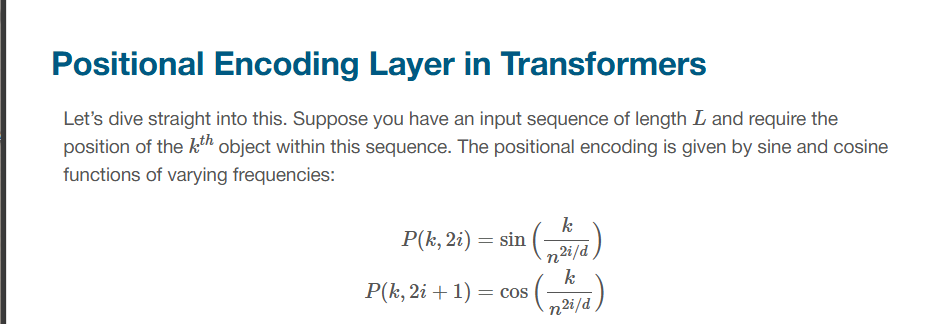

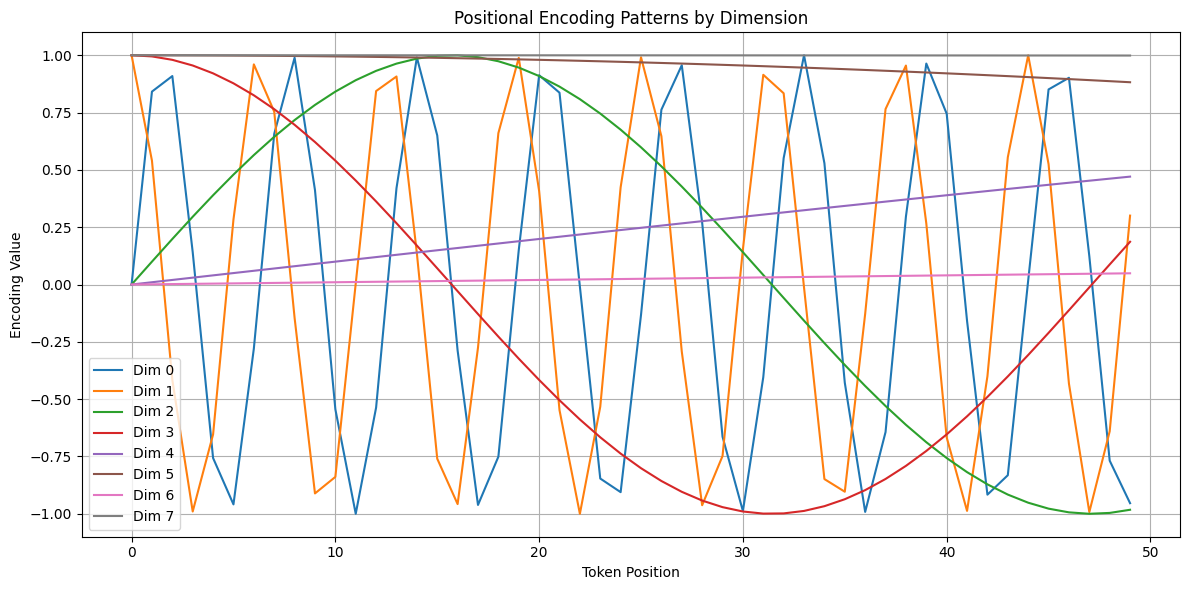

In [ ]:
#(just for illustration and educational purposes, not a part of the code)
import torch
import math
import matplotlib.pyplot as plt

# Positional Encoding visualization
def get_positional_encoding(embed_dim=8, max_len=50):
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
    pos_enc = torch.zeros(max_len, embed_dim)
    pos_enc[:, 0::2] = torch.sin(position * div_term)
    pos_enc[:, 1::2] = torch.cos(position * div_term)
    return pos_enc

# Generate
pos_enc = get_positional_encoding(embed_dim=8, max_len=50)

# Plot
plt.figure(figsize=(12, 6))
for i in range(pos_enc.shape[1]):
    plt.plot(pos_enc[:, i].numpy(), label=f"Dim {i}")
plt.title("Positional Encoding Patterns by Dimension")
plt.xlabel("Token Position")
plt.ylabel("Encoding Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#lower dimensions has higher freq as shown

##Encoder part

#Multihead attention

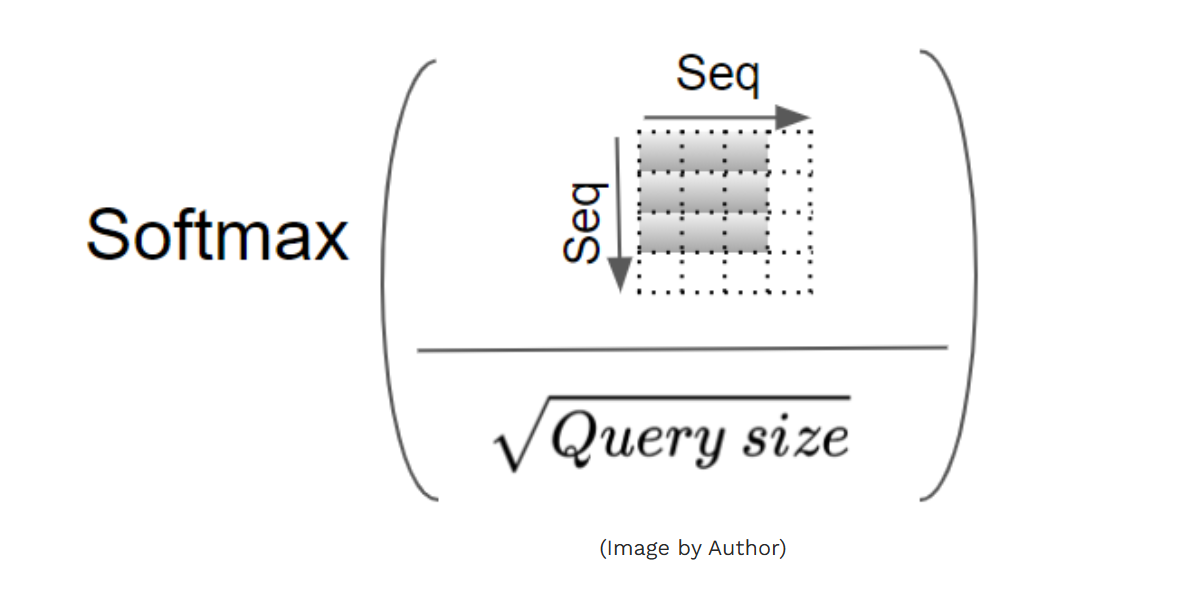

In [ ]:
import torch.nn as nn
import torch.functional as F
import torch

class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim,num_heads):
    #dimension of head will be the embedding dimension // number of heads
    super().__init__()
    assert embed_dim % num_heads == 0, "Embedding dim must be divisible by number of heads"
    #we divide embedding into smaller heads which ensures that head gets an equal piece. if 256-dimensional embedding and 8 heads so we will get dimesion of 32(256/8)
    #I saved the internal variables as we will use it in reshaping the input during projections
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.head_dim = embed_dim//num_heads

    #3 linear layers for k, v and, q
    #q-> queries
    #k -> keys
    #v -> values
    self.q_linear=nn.Linear(embed_dim, embed_dim)
    self.k_linear=nn.Linear(embed_dim, embed_dim)
    self.v_linear=nn.Linear(embed_dim, embed_dim)
   #These layers project your input embeddings into Query (Q), Key (K), and Value (V) spaces. Each word will have 3 different versions of itself for attention.

    self.out_proj = nn.Linear(embed_dim, embed_dim)#here we combine all heads together

  def forward(self,x):#where x is [batch size, sequence length, embed dimension]

    Q = self.q_linear(x)
    K = self.k_linear(x)
    V = self.v_linear(x)
    batch_size, seq_len, _ = Q.size()
    Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
    K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
    V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
  # 1. Calculate scaled dot-product attention scores
    attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)

  # 2. Apply softmax to get attention weights
    attn_weights = torch.softmax(attn_scores, dim=-1)

  # 3. Multiply weights with V to get context
    attn_output = torch.matmul(attn_weights, V)

    # 4. Concatenate heads and project output
    attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
    output = self.out_proj(attn_output)
    return output

adding and normalization

In [ ]:
class AddAndNorm(nn.Module):
  def __init__(self, embed_dim, dropout=0.1):
    super().__init__()
    self.norm = nn.LayerNorm(embed_dim)  # Normalize across embedding
    self.dropout = nn.Dropout(dropout)   # dropout is used to drop every n% node to prevent overfitting

  def forward(self, x, sublayer_output):
        return self.norm(x + self.dropout(sublayer_output)) # Adding residual connection + normalize

fully connected network made up of 2 layers

In [ ]:
class PositionwiseFeedForward(nn.Module):#2 fully connected network layers
    def __init__(self, embed_dim, ff_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)#first layer
        self.relu = nn.ReLU()#activation function
        self.fc2 = nn.Linear(ff_dim, embed_dim)#second layer
        self.dropout = nn.Dropout(dropout)#dropout for optimization

    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))#i added the layers in this form ya rawan
        #if layer 1 is 256 neurons then layer 2 is 1024 thenit will be back to 256

After we finished the encoder parts, lets gather them in one body


In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()

        #Multi-head Self Attention
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        # Add & Norm after attention
        self.norm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)

        # Feedforward
        self.ff = PositionwiseFeedForward(embed_dim, ff_dim, dropout)

        # Add & Norm after feed forward
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout)#droupout and after some search i found out that they make it 0.1

    def forward(self, x):
        #1. Self-Attention -> Add & Norm
        attn_output = self.self_attn(x)
        x = x + self.dropout1(attn_output)  # Add
        x = self.norm1(x)                  # Norm

        #2. FeedForward -> Add & Norm
        ff_output = self.ff(x)
        x = x + self.dropout2(ff_output)   # Add
        x = self.norm2(x)                  # Norm

        return x


In [ ]:
import torch
import torch.nn as nn

class TransformerClassifier(nn.Module):#this is the full classifier after all these madness behind
    def __init__(self, embed_dim, num_heads, ff_dim, num_layers, num_classes, vocab_size, dropout=0.1):
        super().__init__()


        self.embedding = nn.Embedding(vocab_size, embed_dim)# Embedding layer (Assuming input is tokenized and indexed)

        # Stack multiple transformer encoder layers
        self.encoder = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])

        # Classification head
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x: [batch_size, seq_len]

        # Step 1: Embedding lookup
        x = self.embedding(x)  # [batch_size, seq_len, embed_dim]

        # Step 2: Pass through transformer encoder layers
        for layer in self.encoder:
            x = layer(x)  # [batch_size, seq_len, embed_dim]

        # Step 3: Pool the output (you could take the output of the [CLS] token or average)
        x = x.mean(dim=1)  # [batch_size, embed_dim]

        # Step 4: Final classification
        x = self.fc(x)  # [batch_size, num_classes]

        return x

